In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import sys
sys.path.append("..")
from src.data import Dataset
from src.model import NeuralNetwork

# Unscaled training set
Load the unscaled training set from file and get the training and validation split.

In [2]:
d = Dataset(dataset_path="../data/processed/train_unscaled.csv")
x_train, x_val, y_train, y_val = d.get_splits()

# Building the network
Create a network with 4 layers and train. The layer units are estimated folling the rule of thumb of 
$$\mathit{hidden\;neurons} = \frac{2}{3}\mathit{input} + \mathit{output} $$

In [3]:
net = NeuralNetwork(layers=[layers.Dense(units=132, activation='relu'),
                            layers.Dense(units=68, activation='relu'),
                            layers.Dense(units=30, activation='relu'),
                            layers.Dense(10, activation='softmax')], 
                    optimizer=keras.optimizers.RMSprop(), 
                    loss=keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"])

In [4]:
history = net.fit(x_train, 
        y_train, 
        validation_data=(x_val, y_val),
        batch_size=128, 
        epochs=40);

Epoch 1/40
32/32 [==============================] - 1s 10ms/step - loss: 8.7361 - accuracy: 0.2225 - val_loss: 2.1383 - val_accuracy: 0.3267
Epoch 2/40
32/32 [==============================] - 0s 4ms/step - loss: 2.0040 - accuracy: 0.3305 - val_loss: 1.9765 - val_accuracy: 0.3600
Epoch 3/40
32/32 [==============================] - 0s 4ms/step - loss: 1.9655 - accuracy: 0.3480 - val_loss: 2.1702 - val_accuracy: 0.2933
Epoch 4/40
32/32 [==============================] - 0s 4ms/step - loss: 1.8750 - accuracy: 0.3658 - val_loss: 2.0007 - val_accuracy: 0.3622
Epoch 5/40
32/32 [==============================] - 0s 4ms/step - loss: 1.8035 - accuracy: 0.3895 - val_loss: 1.7993 - val_accuracy: 0.3933
Epoch 6/40
32/32 [==============================] - 0s 4ms/step - loss: 1.6132 - accuracy: 0.4586 - val_loss: 1.7170 - val_accuracy: 0.4600
Epoch 7/40
32/32 [==============================] - 0s 4ms/step - loss: 1.4806 - accuracy: 0.5199 - val_loss: 1.6883 - val_accuracy: 0.5022
Epoch 8/40
32/32 [=

In [5]:
net.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 132)               17556     
_________________________________________________________________
dense_5 (Dense)              (None, 68)                9044      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                2070      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
Total params: 28,980
Trainable params: 28,980
Non-trainable params: 0
_________________________________________________________________


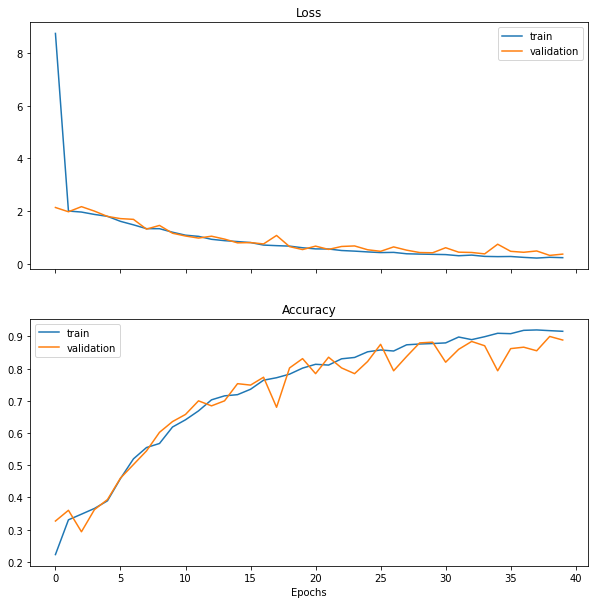

In [6]:
from matplotlib import pyplot as plt

def show_plots():
    fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(10,10))
    plt.xlabel("Epochs")
    ax1.set_title("Loss")

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.legend()
    
show_plots()

# Test folds performance
Test the performance on folds excluded from the training set, and then compute mean accuracy and standard deviation.

In [7]:
import numpy as np

def show_accuracy_loss(scaling):
    loss = []
    accuracy = []

    for fold in [5, 7, 8, 9, 10]:
        td = Dataset(dataset_path=f"../data/processed/test_{fold}_{scaling}.csv", test_size=0)
        x_test, y_test = td.get_splits()
        results = net.model.evaluate(x_test, y_test, batch_size=128)
        loss.append(results[0])
        accuracy.append(results[1])

    print("\nAccuracy:")
    print(f"\tMean: {np.mean(accuracy)} \n\tStandard deviation: {np.std(accuracy)}")

    print("\nLoss:")
    print(f"\tMean: {np.mean(loss)} \n\tStandard deviation: {np.std(loss)}")
    
show_accuracy_loss(scaling="unscaled")

7/7 [==============================] - 0s 3ms/step - loss: 2.7895 - accuracy: 0.5735

Accuracy:
	Mean: 0.546389126777649 
	Standard deviation: 0.03332610347378215

Loss:
	Mean: 3.0483445167541503 
	Standard deviation: 0.3860449012619531


# Scaled training and test folds
To see if scaling makes a difference, the next step is to load the scaled training and test sets and repeat the process.

In [8]:
d = Dataset(dataset_path="../data/processed/train_scaled.csv")
x_train, x_val, y_train, y_val = d.get_splits()

In [9]:
history = net.fit(x_train, 
        y_train, 
        validation_data=(x_val, y_val),
        batch_size=128, 
        epochs=40, 
        verbose=0);

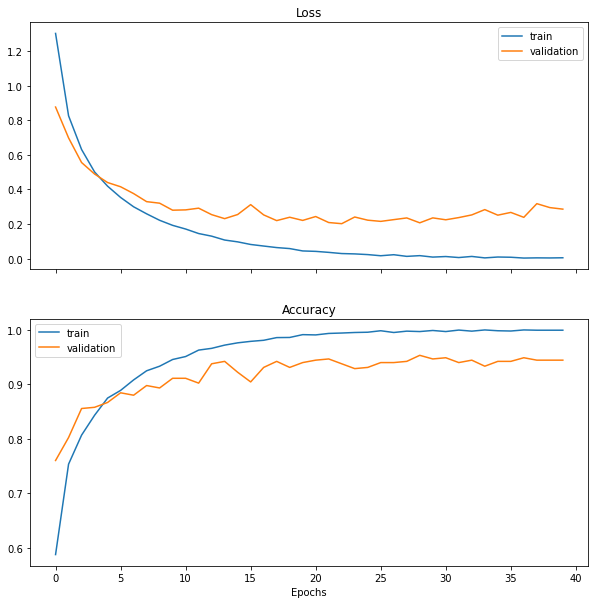

In [10]:
show_plots()

In [11]:
show_accuracy_loss(scaling="scaled")

7/7 [==============================] - 0s 2ms/step - loss: 3.2165 - accuracy: 0.6022

Accuracy:
	Mean: 0.5805455684661865 
	Standard deviation: 0.04352324381428013

Loss:
	Mean: 3.677423858642578 
	Standard deviation: 0.9735984210843864


There's been a small improvement on accuracy, so from now on I'll apply scaling.
The next step is to apply PCA on the dataset, after extracting some more features.